# `titanic.ipynb`
타이타닉 생존자 데이터 셋

In [ ]:
# -q (quiet) 옵션은 설치 로그를 안보여줌(조용히함)
%pip install -q seaborn

In [ ]:
# 타이타닉 데이터셋 불러오기
# (seaborn 기본 내장된 예제 데이터셋)
import seaborn as sns
import pandas as pd

# titanic 데이터 DataFrame
titanic = sns.load_dataset('titanic')

# 처음 5개 행 보기
print("타이타닉 데이터 미리보기:")
print(titanic.head())

# 데이터셋 정보 확인
print("\n데이터셋 정보:")
print(titanic.info())

# 데이터 요약 통계
print("\n데이터 요약 통계:")
print(titanic.describe())

In [ ]:
# Col별 결측치 함계
titanic.isna().sum()
# 승객 등급 등장 빈도 (1, 2, 3 등석)
titanic['pclass'].value_counts()
# 성별 빈도 (남/녀)
titanic['sex'].value_counts()
# 생존 여부 빈도 (생존자/사망자)
titanic['survived'].value_counts()

In [ ]:
# 성별에 따른 생존율
titanic.groupby('sex')['survived'].mean()
# 더 복잡한 통계 가능
titanic.groupby('sex').agg({'survived': ['mean']})

# 승객 등급에 따른 생존율
titanic.groupby('pclass')['survived'].mean()

In [ ]:
# 성별 & 승객 등급에 따른 생존
titanic.groupby(['sex', 'pclass'])['survived'].mean()
# 피벗테이블
titanic.pivot_table(
    values='survived',
    index='sex',
    columns='pclass',
    aggfunc='mean'
)

# 나이 그룹별 생존율
titanic['age_group'] = pd.cut(
    titanic['age'],
    bins=[0, 12, 18, 35, 60, 100, 200],  # 초과 ~ 이하
    labels=['아동', '청소년', '청년', '중장년', '노년', '불사']
)

titanic.head()

#  obeserved 옵션 == 카테고리는 있는데, 해당되는 데이터가 없을 때 표시한다 / 안한다. 
titanic.groupby('age_group', observed=False)['survived'].mean()

# 성별 + 나이그룹으로 생존율 확인
titanic.groupby(['sex', 'age_group'])['survived'].mean()
# 피벗테이블
titanic.pivot_table(
    values='survived',
    index='sex',
    columns='age_group',
    aggfunc='mean'
)

In [ ]:
titanic = sns.load_dataset('titanic')
# 결측치 확인
missing = titanic.isna().sum()
# 결측 있는 항목만 확인
missing[missing > 0]

# 결측 비율
missing_p = titanic.isna().mean() * 100
missing_p[missing_p > 0]

In [ ]:
# 결측치 채우기
# age: 중요한 정보 : 평균/중앙값 대체
# embarked: 가장 많은 사람들이 탄 곳으로 대체
# deck: 추측 불가능(의믹 없음) -> 삭제

# 필요하다면, 카피떠서 진행
titanic_processed = titanic.copy()

# 비어있던 행 마스킹
age_mask = titanic['age'].isna()

# 나이 결측치 채우기 (남녀상관없이 전체평균으로 채움)
mean_age = titanic['age'].mean()
titanic_processed['age'] = titanic['age'].fillna(mean_age)

# 결측치 있는지 재확인
titanic_processed.isna().sum()

# 평균으로 채워진 값들만 확인
titanic_processed.loc[age_mask]


In [ ]:
# 전체평균으로 대체하는게 옳을까..?
# 성별/객실별로 평균을 추정하는건?

# 모든 사람들을 성별/객실 그룹의 평균 나이로 바꾼 Series
print(titanic.groupby(['sex', 'pclass'])['age'].mean())
mean_ages = titanic.groupby(['sex', 'pclass'])['age'].transform('mean')

# titanic 의 age col 중 빈 값만, mean_ages로 채움.
titanic_processed['age'] = titanic['age'].fillna(mean_ages)

# 원래 비어있던 애들만 확인 
titanic_processed.loc[ titanic['age'].isna() ]

In [ ]:
# embarked (탑승 도시) -> 최빈값(가장 많이 탄 곳)

# 비어있는 항구 개수
titanic['embarked'].isna().sum()

# 최빈값 (Series - 벡터)
mode_embarked = titanic['embarked'].mode()[0]  # Series 에서 1개 뽑기
# 빈 값은 최빈값으로 교체
titanic_processed['embarked'] = titanic['embarked'].fillna(mode_embarked)

# 처리 완료 확인 (빈값 0개)
titanic_processed['embarked'].isna().sum()

In [ ]:
# deck 은 77%가 비어있음 -> 삭제
titanic['deck'].isna().mean() * 100  # 빈값 비율

# 'deck' 컬럼은 삭제  - inplace 는 실행하면, 2번째 실행 불가능
titanic_processed.drop('deck', axis=1, inplace=True)

In [100]:
titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  889 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


## 타이타닉 이상치 처리

In [1]:
# 타이타닉 데이터셋 불러오기
# (seaborn 기본 내장된 예제 데이터셋)
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# titanic 데이터 DataFrame
titanic = sns.load_dataset('titanic')

# 수치 데이터에만 집중
numeric_cols = ['age', 'fare']
print("타이타닉 데이터셋 기본 정보:")
print(titanic[numeric_cols].describe())

타이타닉 데이터셋 기본 정보:
              age        fare
count  714.000000  891.000000
mean    29.699118   32.204208
std     14.526497   49.693429
min      0.420000    0.000000
25%     20.125000    7.910400
50%     28.000000   14.454200
75%     38.000000   31.000000
max     80.000000  512.329200


In [27]:
# 결측치(Missing Value) 처리 (이전에 배운 내용 활용)
# 모든 사람들을 성별/객실 그룹의 평균 나이로 바꾼 Series
titanic_processed = titanic.copy()
print(titanic.groupby(['sex', 'pclass'])['age'].mean())

# 각 승객의 그룹에 맞춰서(성별+객실등급) 해당 그룹의 평균으로 일괄 변경
mean_ages = titanic.groupby(['sex', 'pclass'])['age'].transform('mean')
mean_ages

# titanic의 age col 중 빈값만, mean_ages로 채움
titanic_processed['age'] = titanic['age'].fillna(mean_ages)

sex     pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: age, dtype: float64


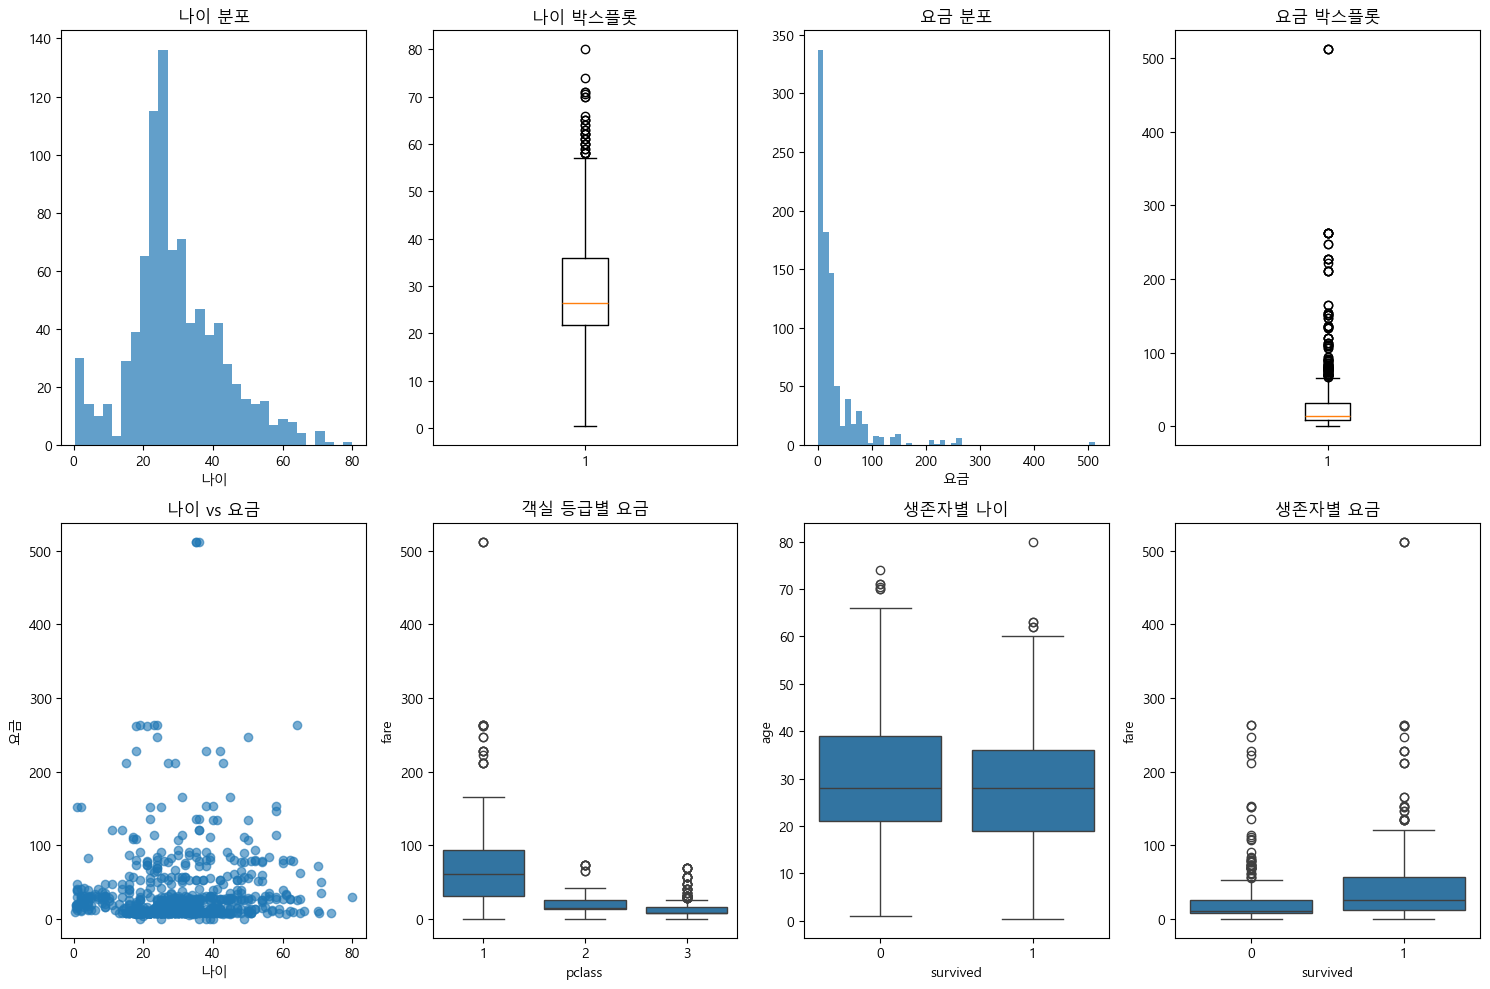

In [28]:
# 결측치 처리 안하면 제대로 시각화 제대로 안나옴

# 1. 이상치 탐지 및 시각화
plt.figure(figsize=(15, 10))

# 나이 분포
plt.subplot(2, 4, 1)
plt.hist(titanic_processed['age'], bins=30, alpha=0.7)
plt.title('나이 분포')
plt.xlabel('나이')

plt.subplot(2, 4, 2)
plt.boxplot(titanic_processed['age'])
plt.title('나이 박스플롯')

# 요금 분포
plt.subplot(2, 4, 3)
plt.hist(titanic['fare'], bins=50, alpha=0.7)
plt.title('요금 분포')
plt.xlabel('요금')

plt.subplot(2, 4, 4)
plt.boxplot(titanic['fare'])
plt.title('요금 박스플롯')

# 산점도
plt.subplot(2, 4, 5)
plt.scatter(titanic['age'], titanic['fare'], alpha=0.6)
plt.xlabel('나이')
plt.ylabel('요금')
plt.title('나이 vs 요금')

# 객실 등급별 요금 분포
plt.subplot(2, 4, 6)
sns.boxplot(x='pclass', y='fare', data=titanic)
plt.title('객실 등급별 요금')

# 생존자별 나이 분포
plt.subplot(2, 4, 7)
sns.boxplot(x='survived', y='age', data=titanic)
plt.title('생존자별 나이')

# 생존자별 요금 분포
plt.subplot(2, 4, 8)
sns.boxplot(x='survived', y='fare', data=titanic)
plt.title('생존자별 요금')

plt.tight_layout()
plt.show()

In [30]:
titanic_processed[numeric_cols].describe()

,age,fare
count,891.000000,891.000000
mean,29.318643,32.204208
std,13.281103,49.693429
min,0.420000,0.000000
25%,21.750000,7.910400
50%,26.507589,14.454200
75%,36.000000,31.000000
max,80.000000,512.329200


In [32]:
# 2. 요금 데이터의 이상치 분석
# IQR 방법으로 이상치 탐지


Q1 = titanic_processed['fare'].quantile(0.25)
Q3 = titanic_processed['fare'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

titanic_fare_outliers = (titanic_processed['fare'] < lower) | (titanic_processed['fare'] > upper)

In [ ]:
# 이상치에 해당하는 승객들 특성 분석
outliers_passengers = tp[fare_outliers]
# 객실 등급 분포
print(outliers_passengers['pclass'].value_counts())
# 성별 분포
print(outliers_passengers['sex'].value_counts())
# 생존 여부
print(outliers_passengers['survived'].value_counts())

# 추가로 Grouping 해서 분석도 가능

pclass
1    104
3      7
2      5
Name: count, dtype: int64


In [38]:
# 3. 객실 등급을 고려한 이상치 분석
# 객실 등급별로 요금 이상치 탐지 (전체 기준 이상치가 객실 별로는 이상치가 아닐 수도 있음)

def detect_outliers_by_group(data: pd.DataFrame, group_col: str, value_col: str):
    """그룹별 이상치 탐지"""
    # 우선 전원 모두 이상치 아님(False)
    outliers = pd.Series(False, data.index)
    # 현재 group_col 기준 유니크한 데이터 (pclass -> 1, 2, 3)
    for group in data[group_col].unique():
        # df[df['pclass'] == 3]['fare'] /  df[df['pclass'] == 1]['fare'] / 
        group_data = data[data[group_col] == group][value_col]
        Q1 = group_data.quantile(0.25)        
        Q3 = group_data.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        group_outliers = (group_data < lower) | (group_data > upper)
        outliers[group_data.index] = group_outliers

    return outliers



In [40]:
# 객실 등급별 이상한 사람들 (T/F mask series)
fare_outliers_by_pclass = detect_outliers_by_group(titanic_processed, 'pclass', 'fare')
# 각 등급별로 따로 선별한 이상치 개수
fare_outliers_by_pclass.sum()

np.int64(79)

In [21]:
# 4. 이상치 처리 방법 적용 및 비교
# 방법 1: 제거

def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    mask = (data[col] >= lower_bound) & (data[col] <= upper_bound)
     
    return data[mask]


titanic_rm1 = remove_outliers_iqr(titanic, 'fare')
titanic_rm1

titanic.describe()
titanic_rm1.describe()


,survived,pclass,age,sibsp,parch,fare
count,775.000000,775.00000,613.000000,775.000000,775.000000,775.000000
mean,0.339355,2.48000,28.946574,0.437419,0.340645,17.822091
std,0.473796,0.73439,14.368139,0.899838,0.785914,13.578085
min,0.000000,1.00000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.00000,20.000000,0.000000,0.000000,7.895800
50%,0.000000,3.00000,28.000000,0.000000,0.000000,13.000000
75%,1.000000,3.00000,37.000000,1.000000,0.000000,26.000000
max,1.000000,3.00000,80.000000,5.000000,6.000000,65.000000


In [22]:
# 방법 2: 윈저화 (95% 백분위수로 제한)

def winsorize_outliers(data, col, lower=5, upper=95):
    lower_bound = data[col].quantile(lower/100)
    upper_bound = data[col].quantile(upper/100)

    data_winsorized = data.copy()
    data_winsorized[col] = data_winsorized[col].clip(lower=lower_bound, upper=upper_bound)
    return data_winsorized

winsorize_outliers(titanic, 'fare')


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
# 방법 3: 객실 등급별 중앙값으로 대체


In [ ]:
# 5. 처리 결과 비교


In [ ]:
# 6. 시각화: 처리 방법별 분포 비교


In [ ]:
# 7. 이상치 처리가 분석에 미치는 영향 확인
